![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    MDS gap-filling of ecosystem fluxes
</b>
</span>

---
**Notebook version**: `2.0` (2 Feb 2025)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- This is the current default gap-filling method for eddy covariance ecosystem fluxes and was implemented following the descriptions in [Reichstein et al., 2005](https://onlinelibrary.wiley.com/doi/10.1111/j.1365-2486.2005.001002.x), see also [Pastorello et al., 2020](https://www.nature.com/articles/s41597-020-0534-3).
- `MDS` stands for `marginal distribution sampling`. The method uses a time window to first identify meteorological
conditions (short-wave incoming radiation, air temperature and VPD) similar to those when the missing data
occurred.
- Gaps are then filled with the mean flux in the time window.

**Note**:
- Results should be similar to other implementations such as [REddyProc](https://github.com/EarthyScience/REddyProc) and [ONEFlux](https://github.com/fluxnet/ONEFlux), but from my testing all packages output (mostly slightly) different numbers after gap-filling

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**

In [2]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

from diive.configs.exampledata import load_exampledata_parquet
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.gapfilling.mds import FluxMDS

warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.5


</br>

# **Docstring** for `FluxMDS`

In [3]:
help(FluxMDS)

Help on class FluxMDS in module diive.pkgs.gapfilling.mds:

class FluxMDS(builtins.object)
 |  FluxMDS(df: pandas.core.frame.DataFrame, flux: str, swin: str, ta: str, vpd: str, swin_tol: list = None, ta_tol: float = 2.5, vpd_tol: float = 0.5, avg_min_n_vals: int = 5, verbose: int = 1)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, flux: str, swin: str, ta: str, vpd: str, swin_tol: list = None, ta_tol: float = 2.5, vpd_tol: float = 0.5, avg_min_n_vals: int = 5, verbose: int = 1)
 |      Gap-filling for ecosystem fluxes, based on marginal distribution sampling (MDS
 |      described in Reichstein et al. (2005).
 |      
 |      Missing values are replaced by the average *flux* value during
 |      similar meteorological conditions.
 |      
 |      The MDS method in diive was implemented following the descriptions in
 |      Reichstein et al. (2005) and Vekuri et al. (2023).
 |      
 |      References:
 |          Reichstein et al. (2005). On the

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.059 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
df = source_df.copy()
# This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
lowquality = df["QCF_NEE"] > 0  
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only
locs = df.index.year == 2022
df = df.loc[locs, :].copy()

In [6]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,4438.000000,17520.000000,17520.000000,17520.000000
mean,-3.677627,5.609282,3.527299,164.732211
std,5.520599,7.753763,4.073853,263.544729
min,-22.407000,-15.073000,0.000000,0.000000
25%,-7.437750,-0.274000,0.617000,0.000000
50%,-3.916500,5.587000,2.237000,4.126500
75%,0.616750,11.117000,4.779000,248.027000
max,18.455000,26.587000,27.282000,1084.135000


In [7]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2022-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,364 days 23:30:00
NOV,4438
MISSING,13082
MISSING_PERC,74.66895
MEAN,-3.677627
MEDIAN,-3.9165
SD,5.520599
VAR,30.47701


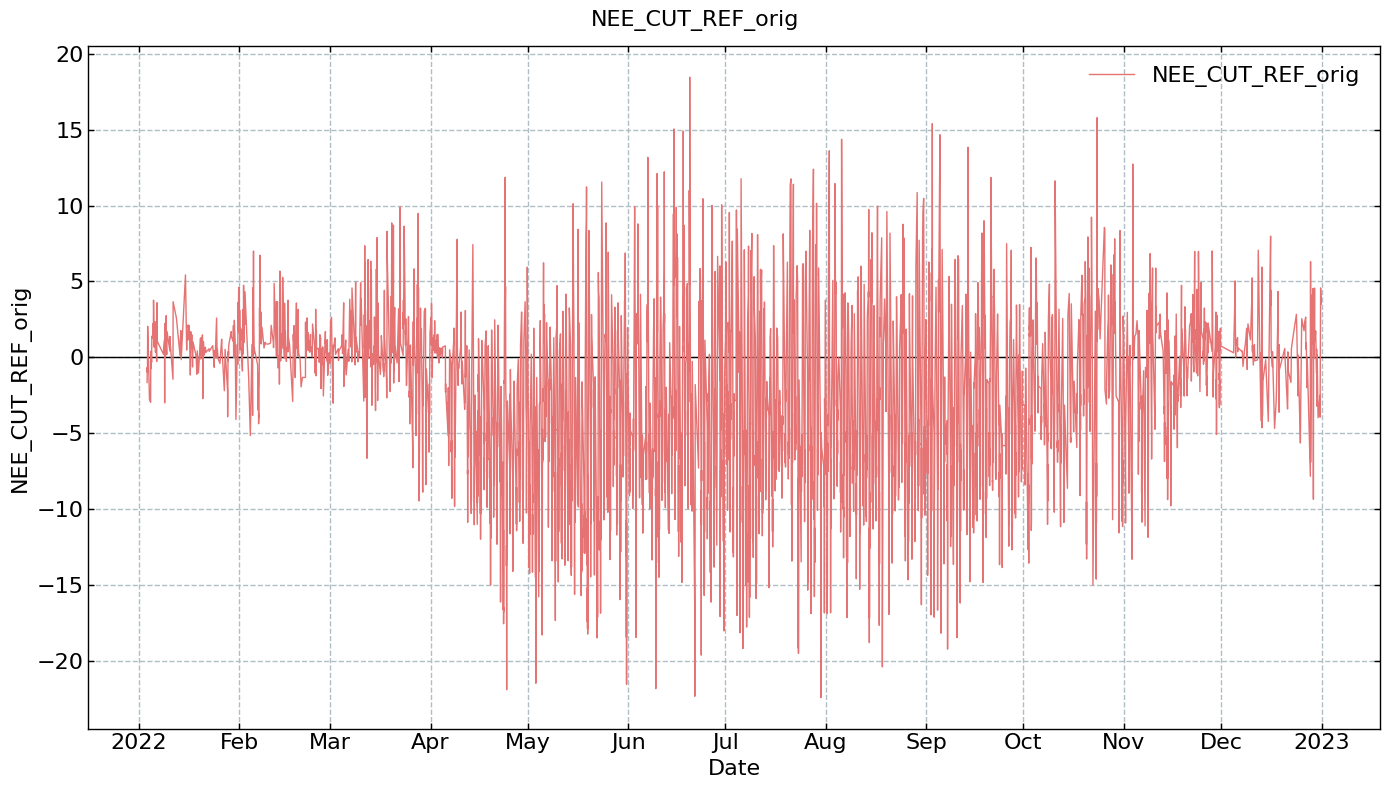

In [8]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Example without restricting nighttime gap-filling
- Parameter `avg_min_n_vals` is set to `5`: average for filling nighttime gaps is calculated from at least 5 available flux values
- Similar to other implementations of the `MDS` algorithm (ICOS, FLUXNET, REddyProc ...)

### Initialize MDS

In [10]:
mds = FluxMDS(
    df=df,
    flux='NEE_CUT_REF_orig',
    ta='Tair_f',
    swin='Rg_f',
    vpd='VPD_f',
    swin_tol=[20, 50],
    ta_tol=2.5,
    vpd_tol=0.5,  # kPa; 5 hPa is default for reference
    avg_min_n_vals=5
)

</br>

### Run gap-filling

In [11]:
%%time
mds.run()

MDS gap-filling quality 1    using SW_IN, TA, VPD in 7 days window ...
MDS gap-filling quality 2    using SW_IN, TA, VPD in 14 days window ...
MDS gap-filling quality 3    using SW_IN in 7 days window ...
MDS gap-filling quality 4    using mean diurnal cycle of flux in 0 days, 1 hours window ...
MDS gap-filling quality 5    using mean diurnal cycle of flux in 1 days, 1 hours window ...
MDS gap-filling quality 6    using SW_IN, TA, VPD in 21 days window ...
MDS gap-filling quality 7    using SW_IN, TA, VPD in 28 days window ...
MDS gap-filling quality 8    using SW_IN in 14 days window ...
MDS gap-filling quality 9    using SW_IN, TA, VPD in 35 days window ...
MDS gap-filling quality 10    using SW_IN, TA, VPD in 42 days window ...
MDS gap-filling quality 11    using SW_IN, TA, VPD in 49 days window ...
MDS gap-filling quality 12    using SW_IN, TA, VPD in 56 days window ...
MDS gap-filling quality 13    using SW_IN, TA, VPD in 63 days window ...
MDS gap-filling quality 14    using SW_I

</br>

### Results

#### Dataframe with gap-filled time series

In [12]:
mds.gapfilling_df_

,NEE_CUT_REF_orig,Rg_f,Tair_f,VPD_f,.TIMESTAMP,NEE_CUT_REF_orig_gfMDS,FLAG_NEE_CUT_REF_orig_gfMDS_ISFILLED,.PREDICTIONS,.PREDICTIONS_SD,.PREDICTIONS_COUNTS,.PREDICTIONS_QUALITY,.START,.END,.Rg_f_LOWERLIM,.Rg_f_UPPERLIM,.Tair_f_LOWERLIM,.Tair_f_UPPERLIM,.VPD_f_LOWERLIM,.VPD_f_UPPERLIM
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,
2022-01-01 00:15:00,NaN,0.0,3.977,4.709,2022-01-01 00:15:00,0.877652,3.0,0.877652,1.111477,23.0,3,2021-12-25 00:15:00,2022-01-08 00:15:00,-20.0,20.0,1.477,6.477,4.209,5.209
2022-01-01 00:45:00,NaN,0.0,4.027,4.767,2022-01-01 00:45:00,0.877652,3.0,0.877652,1.111477,23.0,3,2021-12-25 00:45:00,2022-01-08 00:45:00,-20.0,20.0,1.527,6.527,4.267,5.267
2022-01-01 01:15:00,NaN,0.0,3.603,4.481,2022-01-01 01:15:00,0.877652,3.0,0.877652,1.111477,23.0,3,2021-12-25 01:15:00,2022-01-08 01:15:00,-20.0,20.0,1.103,6.103,3.981,4.981
2022-01-01 01:45:00,NaN,0.0,3.213,4.203,2022-01-01 01:45:00,0.877652,3.0,0.877652,1.111477,23.0,3,2021-12-25 01:45:00,2022-01-08 01:45:00,-20.0,20.0,0.713,5.713,3.703,4.703
2022-01-01 02:15:00,NaN,0.0,3.097,4.124,2022-01-01 02:15:00,0.877652,3.0,0.877652,1.111477,23.0,3,2021-12-25 02:15:00,2022-01-08 02:15:00,-20.0,20.0,0.597,5.597,3.624,4.624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,NaN,0.0,3.463,2.210,2022-12-31 21:45:00,1.474048,3.0,1.474048,2.192367,21.0,3,2022-12-24 21:45:00,2023-01-07 21:45:00,-20.0,20.0,0.963,5.963,1.710,2.710
2022-12-31 22:15:00,3.518,0.0,5.283,3.327,2022-12-31 22:15:00,3.518000,0.0,1.474048,2.192367,21.0,3,2022-12-24 22:15:00,2023-01-07 22:15:00,-20.0,20.0,2.783,7.783,2.827,3.827
2022-12-31 22:45:00,NaN,0.0,5.537,3.467,2022-12-31 22:45:00,1.474048,3.0,1.474048,2.192367,21.0,3,2022-12-24 22:45:00,2023-01-07 22:45:00,-20.0,20.0,3.037,8.037,2.967,3.967


#### Gap-filled variable

In [13]:
print(f"The variable name of the gap-filled time series is {mds.target_gapfilled}.")
mds.target_gapfilled

The variable name of the gap-filled time series is NEE_CUT_REF_orig_gfMDS.


'NEE_CUT_REF_orig_gfMDS'

</br>

#### Report

In [14]:
mds.report()


NEE_CUT_REF_orig before gap-filling:
    17520 potential values
    4438 available values
    13082 missing values

NEE_CUT_REF_orig after gap-filling (NEE_CUT_REF_orig_gfMDS):
    17520 potential values
    17520 available values
    0 missing values
    2.407 predictions mean quality across all records (1=best)

Gap-filling quality flags (FLAG_NEE_CUT_REF_orig_gfMDS_ISFILLED):
    Directly measured: 4438 values (flag=0)
    Gap-filling quality 1.0: 4230 values (flag=1.0)
    Gap-filling quality 2.0: 1939 values (flag=2.0)
    Gap-filling quality 3.0: 6493 values (flag=3.0)
    Gap-filling quality 5.0: 1 values (flag=5.0)
    Gap-filling quality 6.0: 9 values (flag=6.0)
    Gap-filling quality 7.0: 23 values (flag=7.0)
    Gap-filling quality 8.0: 347 values (flag=8.0)
    Gap-filling quality 9.0: 2 values (flag=9.0)
    Gap-filling quality 12.0: 1 values (flag=12.0)
    Gap-filling quality 16.0: 2 values (flag=16.0)
    Gap-filling quality 18.0: 1 values (flag=18.0)
    Gap-filling 

#### Test scores
Abbreviations:
- `mae` ... mean absolute error
- `medae` ... median absolute error
- `mse` ... mean squared error
- `rmse` ... root mean squared error
- `mape` ... mean absolute percentage error
- `maxe` ... max error
- `r2` ... r2 score

In [15]:
mds.scores_

{'mae': np.float64(2.0227391329325033),
 'medae': np.float64(1.489888888888888),
 'mse': np.float64(7.525601423496617),
 'rmse': np.float64(2.743282964532937),
 'mape': np.float64(1.6568484542129849),
 'maxe': np.float64(14.513515151515154),
 'r2': 0.7530171944480702,
 'mean_quality_flag_gap_predictions': np.float64(2.4089588747897874)}

</br>

### Plot

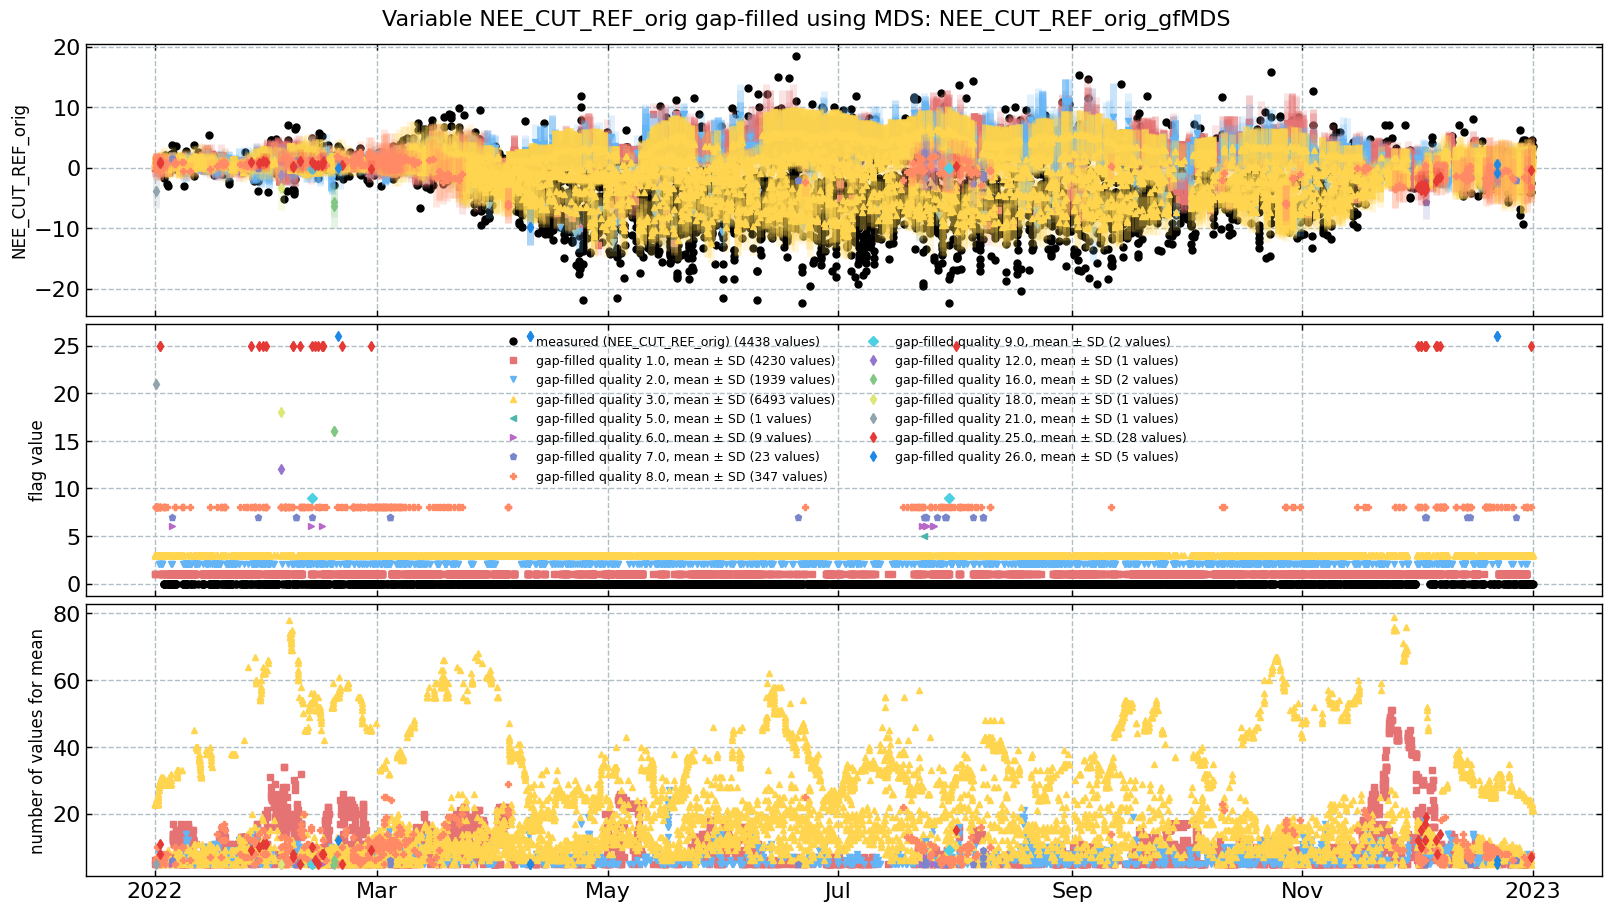

In [16]:
mds.showplot()

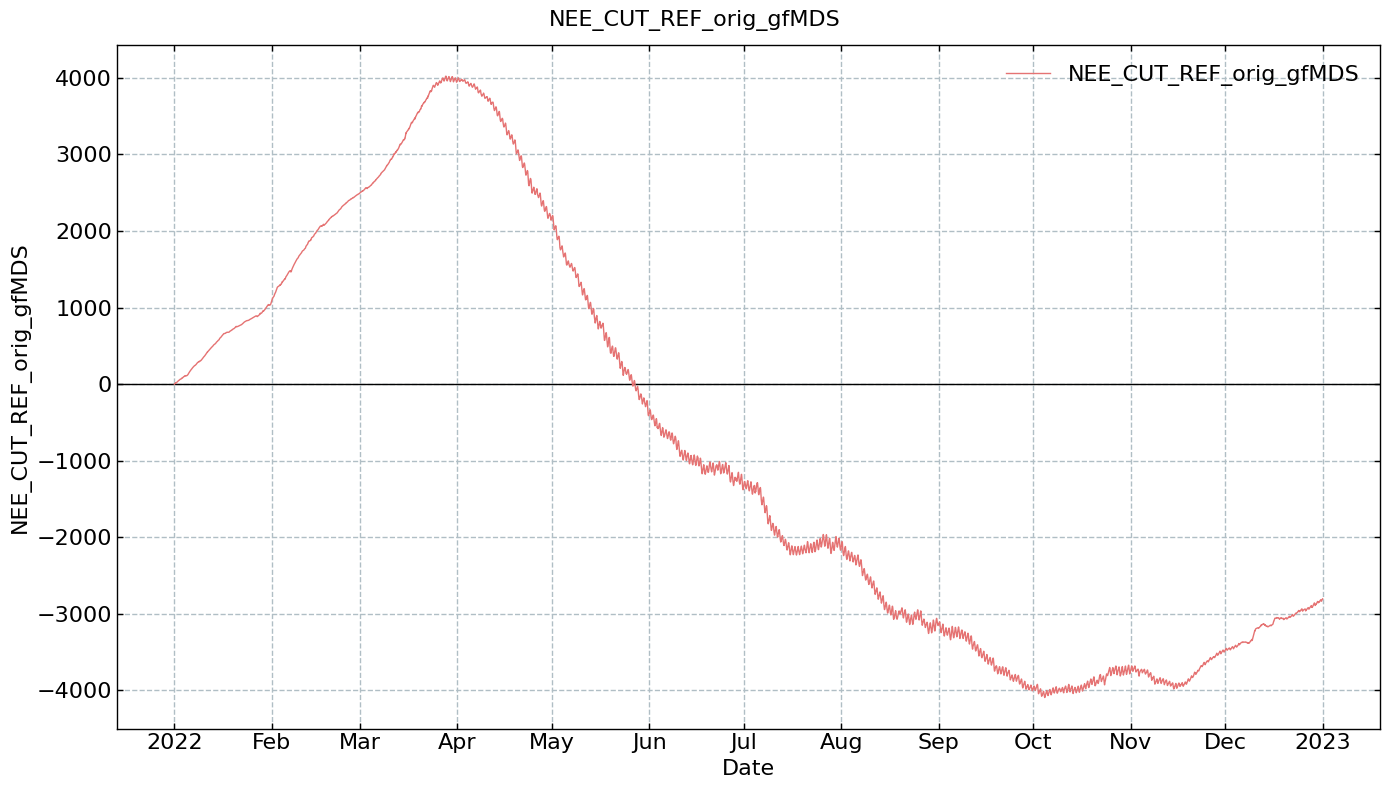

In [17]:
TimeSeries(series=mds.gapfilling_df_[mds.target_gapfilled].cumsum()).plot()

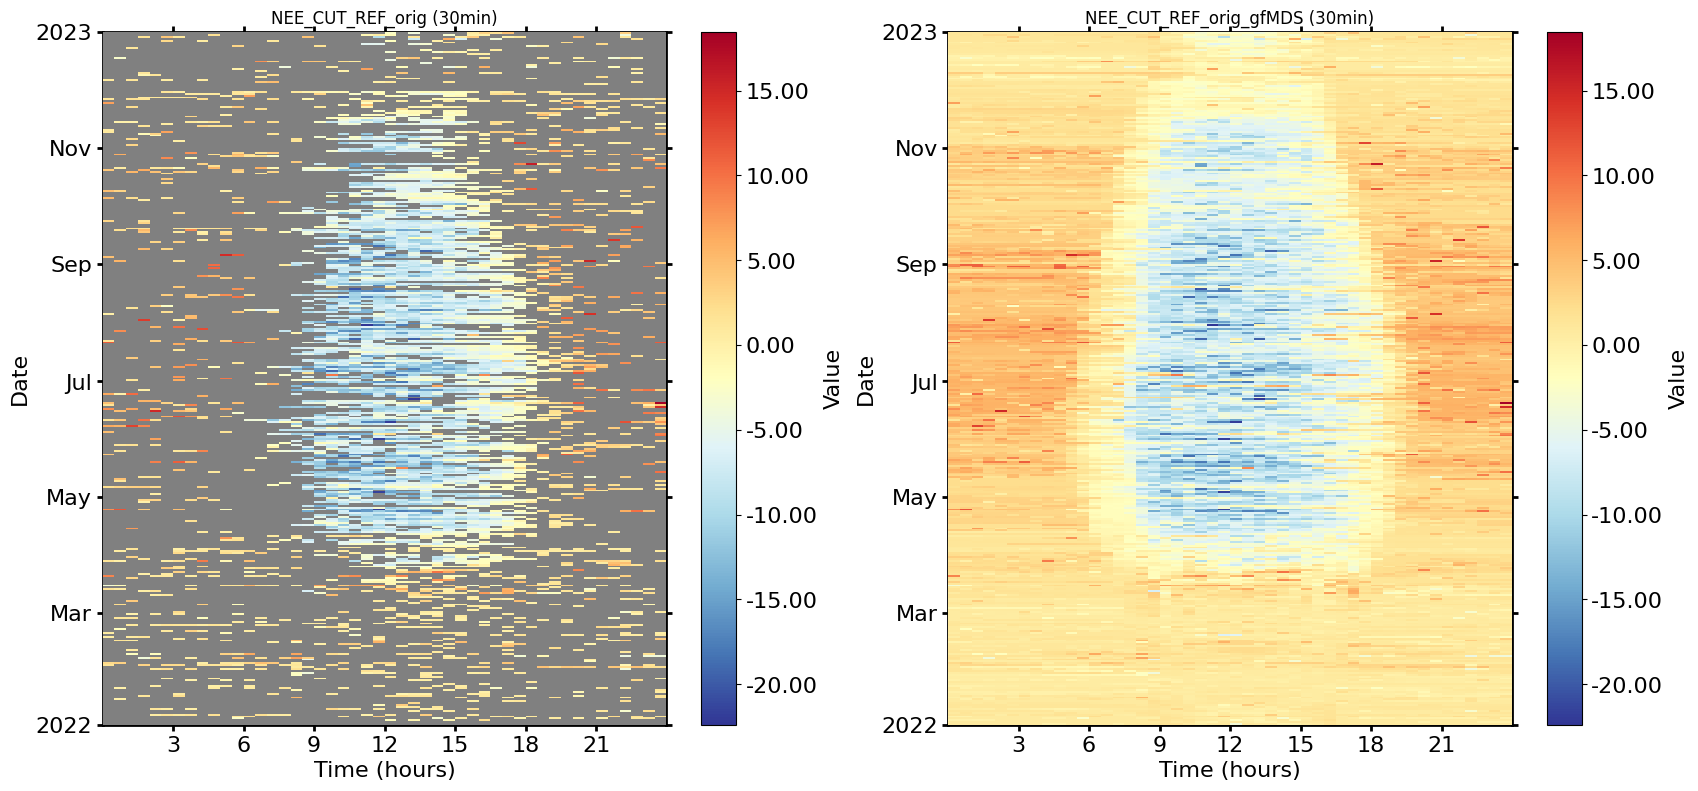

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 9))
HeatmapDateTime(series=mds.gapfilling_df_[mds.flux], ax=axs[0]).plot()
HeatmapDateTime(series=mds.gapfilling_df_[mds.target_gapfilled], ax=axs[1]).plot()

</br>

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [19]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-02-02 00:21:41
